# Load library

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import my_utils as mu
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torchvision # used to load data
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

# Load Data and transform data

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Normalise data
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Normalise data

# Loading training and testing set
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform_train) # 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Visualise Inputs

In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

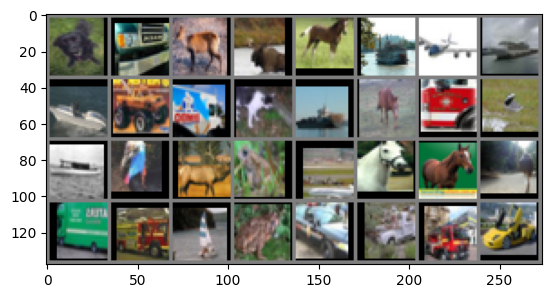

dog   truck deer  deer  horse ship  plane ship  ship  truck truck cat   ship  horse truck bird  ship  bird  deer  frog  plane horse horse bird  truck truck ship  frog  car   truck truck car  


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Resnet 18 Model

In [13]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)     

        identity = self.shortcut(identity)

        out += identity
        out = self.relu2(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            ResNetBlock(64, 128, stride=2),
            ResNetBlock(128, 128),
            ResNetBlock(128, 256, stride=2),
            ResNetBlock(256, 256),
            ResNetBlock(256, 512, stride=2),
            ResNetBlock(512, 512)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),  
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Load model, loss and optimiser

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet18()
net.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Model Summary

In [19]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
      ResNetBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

# Train model and visualise training and testing

In [22]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device, writer):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    epoch_data = []
    writer.add_text('Hyperparameters', f'Learning Rate: {optimizer.param_groups[0]["lr"]}', 0)
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
                
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
            
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch+1, (None, None, test_acc))
        writer.add_scalar('Test/Accuracy', test_acc, epoch)
        
        # Collect epoch data
        epoch_data.append({
            'epoch': epoch + 1,
            'loss': train_loss,
            'train_acc': train_acc,
            'test_acc': test_acc
        })
        
    # After all epochs, print the collected data
    print("-------------------------------------------------------")
    for data in epoch_data:
        print(f"Epoch {data['epoch']}, Loss: {data['loss']:.3f}, "
              f"Train Acc: {data['train_acc']:.3f}, Test Acc: {data['test_acc']:.3f}")
        
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

    
    writer.close()


-------------------------------------------------------
Epoch 1, Loss: 1.427, Train Acc: 0.476, Test Acc: 0.593
Epoch 2, Loss: 0.954, Train Acc: 0.663, Test Acc: 0.742
Epoch 3, Loss: 0.750, Train Acc: 0.737, Test Acc: 0.769
Epoch 4, Loss: 0.634, Train Acc: 0.781, Test Acc: 0.793
Epoch 5, Loss: 0.558, Train Acc: 0.808, Test Acc: 0.817
Epoch 6, Loss: 0.502, Train Acc: 0.828, Test Acc: 0.830
Epoch 7, Loss: 0.462, Train Acc: 0.841, Test Acc: 0.848
Epoch 8, Loss: 0.416, Train Acc: 0.856, Test Acc: 0.828
Epoch 9, Loss: 0.388, Train Acc: 0.865, Test Acc: 0.849
Epoch 10, Loss: 0.359, Train Acc: 0.875, Test Acc: 0.864
Epoch 11, Loss: 0.337, Train Acc: 0.884, Test Acc: 0.860
Epoch 12, Loss: 0.314, Train Acc: 0.893, Test Acc: 0.871
Epoch 13, Loss: 0.297, Train Acc: 0.897, Test Acc: 0.879
Epoch 14, Loss: 0.279, Train Acc: 0.904, Test Acc: 0.871
Epoch 15, Loss: 0.257, Train Acc: 0.911, Test Acc: 0.885
Epoch 16, Loss: 0.242, Train Acc: 0.915, Test Acc: 0.884
Epoch 17, Loss: 0.230, Train Acc: 0.920, 

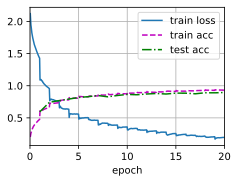

In [24]:
writer = SummaryWriter('runs/ResNet18_CIFAR10')

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(net, trainloader, testloader, loss, num_epochs, optimizer, device, writer)

In [ ]:
torch.cuda.empty_cache()

# Visualise Test set predictions

In [85]:
def visualize_random_predictions(net, data_iter, device, num_images=10):
    classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    net.eval()  
    images, labels = next(iter(data_iter))  
    
    # Randomly select image indices
    indices = np.random.choice(len(images), num_images, replace=False)
    
    images_selected = images[indices].to(device)
    labels_selected = labels[indices]
    
    with torch.no_grad():
        pred_probs = net(images_selected)
        pred_labels = torch.argmax(pred_probs, axis=1)
    
    images_selected = images_selected.cpu()
    pred_labels = pred_labels.cpu()
    
    # Plotting
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))  
    for i, ax in enumerate(axs.flat):
        img = images_selected[i] / 2 + 0.5
        ax.imshow(np.transpose(img, (1, 2, 0))) 
        true_label = classes[labels_selected[i]]
        pred_label = classes[pred_labels[i]]
        ax.set_title(f'Pred: {pred_label}, True: {true_label}')
        ax.axis('off')
    
    plt.show()


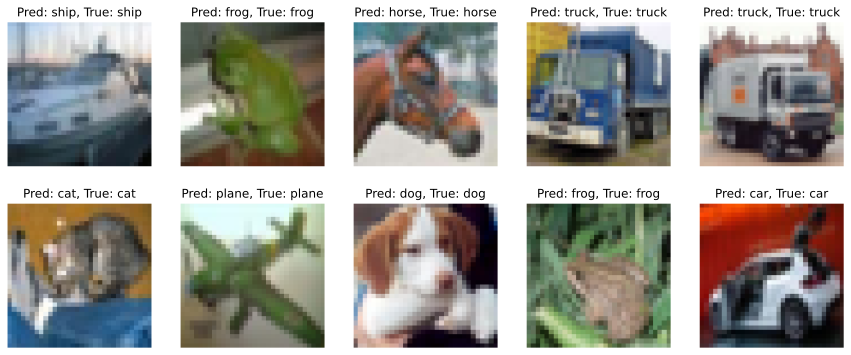

In [87]:
visualize_random_predictions(net, testloader, device)